In [ ]:
from __future__ import division
from __future__ import print_function

import time
import numpy as np
import scipy.sparse as sp
import networkx as nx
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

from sklearn.metrics import (precision_recall_curve,PrecisionRecallDisplay)
from matplotlib import pyplot
import seaborn as sns

Instructions for updating:
non-resource variables are not supported in the long term


Various Utility Functions

In [ ]:
def load_data():
    g = nx.read_edgelist('1912.edges')
    adj = nx.adjacency_matrix(g)
    return adj

 #Create a weight variable with Glorot & Bengio (AISTATS 2010) initialization.
def weight_variable_glorot(input_dim, output_dim, name=""):
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = tf.random_uniform(
        [input_dim, output_dim], minval=-init_range,
        maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def dropout_sparse(x, keep_prob, num_nonzero_elems):
    noise_shape = [num_nonzero_elems]
    random_tensor = keep_prob
    random_tensor += tf.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse_retain(x, dropout_mask)
    return pre_out * (1. / keep_prob)


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape


def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(adj_normalized, adj, features, placeholders):
    feed_dict = dict()
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['adj']: adj_normalized})
    feed_dict.update({placeholders['adj_orig']: adj})
    return feed_dict


def mask_test_edges(adj):
    # Function to build test set with 2% positive links
    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()

    adj_triu = sp.triu(adj)
    adj_tuple = sparse_to_tuple(adj_triu)
    edges = adj_tuple[0]
    edges_all = sparse_to_tuple(adj)[0]
    num_test = int(np.floor(edges.shape[0] / 50.))
    num_val = int(np.floor(edges.shape[0] / 50.))

    all_edge_idx = np.arange(edges.shape[0])
    np.random.shuffle(all_edge_idx)
    val_edge_idx = all_edge_idx[:num_val]
    test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]
    test_edges = edges[test_edge_idx]
    val_edges = edges[val_edge_idx]
    train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)

    def ismember(a, b):
        rows_close = np.all((a - b[:, None]) == 0, axis=-1)
        return np.any(rows_close)

    test_edges_false = []
    while len(test_edges_false) < len(test_edges):
        n_rnd = len(test_edges) - len(test_edges_false)
        rnd = np.random.randint(0, adj.shape[0], size=2 * n_rnd)
        idxs_i = rnd[:n_rnd]
        idxs_j = rnd[n_rnd:]
        for i in range(n_rnd):
            idx_i = idxs_i[i]
            idx_j = idxs_j[i]
            if idx_i == idx_j:
                continue
            if ismember([idx_i, idx_j], edges_all):
                continue
            if test_edges_false:
                if ismember([idx_j, idx_i], np.array(test_edges_false)):
                    continue
                if ismember([idx_i, idx_j], np.array(test_edges_false)):
                    continue
            test_edges_false.append([idx_i, idx_j])

    val_edges_false = []
    while len(val_edges_false) < len(val_edges):
        n_rnd = len(val_edges) - len(val_edges_false)
        rnd = np.random.randint(0, adj.shape[0], size=2 * n_rnd)
        idxs_i = rnd[:n_rnd]
        idxs_j = rnd[n_rnd:]
        for i in range(n_rnd):
            idx_i = idxs_i[i]
            idx_j = idxs_j[i]
            if idx_i == idx_j:
                continue
            if ismember([idx_i, idx_j], train_edges):
                continue
            if ismember([idx_j, idx_i], train_edges):
                continue
            if ismember([idx_i, idx_j], val_edges):
                continue
            if ismember([idx_j, idx_i], val_edges):
                continue
            if val_edges_false:
                if ismember([idx_j, idx_i], np.array(val_edges_false)):
                    continue
                if ismember([idx_i, idx_j], np.array(val_edges_false)):
                    continue
            val_edges_false.append([idx_i, idx_j])

    # Re-build adj matrix
    data = np.ones(train_edges.shape[0])
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T

    return adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false


def get_roc_score(edges_pos, edges_neg):
    feed_dict.update({placeholders['dropout']: 0})
    emb = sess.run(model.embeddings, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

# to get precision
#from sklearn.metrics import plot_precision_recall_curve
def get_pre_rec(edges_pos, edges_neg):
    feed_dict.update({placeholders['dropout']: 0})
    emb = sess.run(model.embeddings, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    for i in range (len(preds_all)):
        a = np.mean(preds_all)
        if preds_all[i]< a :
            preds_all[i] = 0
        else :
            preds_all[i] = 1

    recallVal = recall_score(labels_all, preds_all)
    precisionVal, recallVal, thresholds = precision_recall_curve(labels_all, preds_all)
    return  precisionVal, recallVal

# to getconfusion matrix
from sklearn.metrics import confusion_matrix
def get_conf(edges_pos, edges_neg):
    feed_dict.update({placeholders['dropout']: 0})
    emb = sess.run(model.embeddings, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    for i in range (len(preds_all)):
        a = np.mean(preds_all)
        if preds_all[i]< a :
            preds_all[i] = 0
        else :
            preds_all[i] = 1

    cf_matrix = confusion_matrix(labels_all, preds_all)
    return cf_matrix


In [ ]:
# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings
flags = tf.app.flags
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 50, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 32, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 32, 'Number of units in hidden layer 2.') # originally 16
flags.DEFINE_float('dropout', 0.1, 'Dropout rate (1 - keep probability).')

Define Convolutional Layers for GCN Model

In [ ]:
class GraphConvolution():
    """Basic graph convolution layer for undirected graph without edge labels."""
    def __init__(self, input_dim, output_dim, adj, name, dropout=0., act=tf.nn.relu):
        self.name = name
        self.vars = {}
        self.issparse = False
        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim, name='weights')
        self.dropout = dropout
        self.adj = adj
        self.act = act

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            x = inputs
            x = tf.nn.dropout(x, 1-self.dropout)
            x = tf.matmul(x, self.vars['weights'])
            x = tf.sparse_tensor_dense_matmul(self.adj, x)
            outputs = self.act(x)
        return outputs


class GraphConvolutionSparse():
    """Graph convolution layer for sparse inputs."""
    def __init__(self, input_dim, output_dim, adj, features_nonzero, name, dropout=0., act=tf.nn.relu):
        self.name = name
        self.vars = {}
        self.issparse = False
        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim, name='weights')
        self.dropout = dropout
        self.adj = adj
        self.act = act
        self.issparse = True
        self.features_nonzero = features_nonzero

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            x = inputs
            x = dropout_sparse(x, 1-self.dropout, self.features_nonzero)
            x = tf.sparse_tensor_dense_matmul(x, self.vars['weights'])
            x = tf.sparse_tensor_dense_matmul(self.adj, x)
            outputs = self.act(x)
        return outputs


class InnerProductDecoder():
    """Decoder model layer for link prediction."""
    def __init__(self, input_dim, name, dropout=0., act=tf.nn.sigmoid):
        self.name = name
        self.issparse = False
        self.dropout = dropout
        self.act = act

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            inputs = tf.nn.dropout(inputs, 1-self.dropout)
            x = tf.transpose(inputs)
            x = tf.matmul(inputs, x)
            x = tf.reshape(x, [-1])
            outputs = self.act(x)
        return outputs

Specify the Architecture of our GCN Model

In [ ]:
class GCNModel():
    def __init__(self, placeholders, num_features, features_nonzero, name):
        self.name = name
        self.inputs = placeholders['features']
        self.input_dim = num_features
        self.features_nonzero = features_nonzero
        self.adj = placeholders['adj']
        self.dropout = placeholders['dropout']
        with tf.variable_scope(self.name):
            self.build()

    def build(self):
        self.hidden1 = GraphConvolutionSparse(
            name='gcn_sparse_layer',
            input_dim=self.input_dim,
            output_dim=FLAGS.hidden1,
            adj=self.adj,
            features_nonzero=self.features_nonzero,
            act=tf.nn.relu,
            dropout=self.dropout)(self.inputs)

        self.embeddings = GraphConvolution(
            name='gcn_dense_layer',
            input_dim=FLAGS.hidden1,
            output_dim=FLAGS.hidden2,
            adj=self.adj,
            act=lambda x: x,
            dropout=self.dropout)(self.hidden1)

        self.reconstructions = InnerProductDecoder(
            name='gcn_decoder',
            input_dim=FLAGS.hidden2,
            act=lambda x: x)(self.embeddings)

Specify the GCN Optimizer

In [ ]:
class Optimizer():
    def __init__(self, preds, labels, num_nodes, num_edges):
        pos_weight = float(num_nodes**2 - num_edges) / num_edges
        norm = num_nodes**2 / float((num_nodes**2 - num_edges) * 2)

        preds_sub = preds
        labels_sub = labels

        self.cost = norm * tf.reduce_mean(
            tf.nn.weighted_cross_entropy_with_logits(
                logits=preds_sub, targets=labels_sub, pos_weight=pos_weight))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)  # Adam Optimizer

        self.opt_op = self.optimizer.minimize(self.cost)
        self.grads_vars = self.optimizer.compute_gradients(self.cost)

Training the GCN Model and Evaluating its Accuracy on a Test Set

In [ ]:
adj = load_data()
num_nodes = adj.shape[0]
num_edges = adj.sum()
# Featureless
features = sparse_to_tuple(sp.identity(num_nodes))
num_features = features[2][1]
features_nonzero = features[1].shape[0]

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

adj_norm = preprocess_graph(adj)

In [ ]:
tf.app.flags.DEFINE_string('f', '', 'kernel')
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

# Create model
model = GCNModel(placeholders, num_features, features_nonzero, name='facebook_gcn')

# Create optimizer
with tf.name_scope('optimizer'):
    opt = Optimizer(
        preds=model.reconstructions,
        labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'], validate_indices=False), [-1]),
        num_nodes=num_nodes,
        num_edges=num_edges)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
targets is deprecated, use labels instead


In [ ]:
# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer()) # training happens

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

# Train model
for epoch in range(FLAGS.epochs):
    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # One update of parameter matrices
    _, avg_cost = sess.run([opt.opt_op, opt.cost], feed_dict=feed_dict)
    # Performance on validation set
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)


    print("Epoch:", '%04d' % (epoch + 1),
          "train_loss=", "{:.5f}".format(avg_cost),
          "val_roc=", "{:.5f}".format(roc_curr),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print('Optimization Finished!')

roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
#precision, recall = get_pre_rec(test_edges, test_edges_false)

precisionVal, recallVal= get_pre_rec(test_edges, test_edges_false)

cf_matrix = get_conf(test_edges, test_edges_false)

test_edges[1], test_edges_false[1]
print('Test ROC score: {:.5f}'.format(roc_score))
print('Test AP score: {:.5f}'.format(ap_score))

pyplot.show()


Epoch: 0001 train_loss= 0.68475 val_roc= 0.96037 val_ap= 0.95227 time= 0.27667
Epoch: 0002 train_loss= 0.68449 val_roc= 0.96852 val_ap= 0.96108 time= 0.09872
Epoch: 0003 train_loss= 0.68369 val_roc= 0.97022 val_ap= 0.96806 time= 0.09637
Epoch: 0004 train_loss= 0.68209 val_roc= 0.97159 val_ap= 0.97055 time= 0.09392
Epoch: 0005 train_loss= 0.67873 val_roc= 0.97246 val_ap= 0.97130 time= 0.09584
Epoch: 0006 train_loss= 0.67391 val_roc= 0.97295 val_ap= 0.97162 time= 0.09300
Epoch: 0007 train_loss= 0.66574 val_roc= 0.97316 val_ap= 0.97168 time= 0.09486
Epoch: 0008 train_loss= 0.65504 val_roc= 0.97332 val_ap= 0.97166 time= 0.09048
Epoch: 0009 train_loss= 0.64010 val_roc= 0.97319 val_ap= 0.97147 time= 0.08612
Epoch: 0010 train_loss= 0.61876 val_roc= 0.97278 val_ap= 0.97095 time= 0.08909
Epoch: 0011 train_loss= 0.59210 val_roc= 0.97220 val_ap= 0.97027 time= 0.09146
Epoch: 0012 train_loss= 0.56158 val_roc= 0.97151 val_ap= 0.96950 time= 0.09221
Epoch: 0013 train_loss= 0.53016 val_roc= 0.97094 val

In [ ]:
# for curve plotting   ------


# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

# Train model
for epoch in range(FLAGS.epochs):
    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # One update of parameter matrices
    _, avg_cost = sess.run([opt.opt_op, opt.cost], feed_dict=feed_dict)
    # Performance on validation set


    #precision, recall = get_pre_rec(val_edges, val_edges_false)
    precisionVal, recallVal= get_pre_rec(test_edges, test_edges_false)


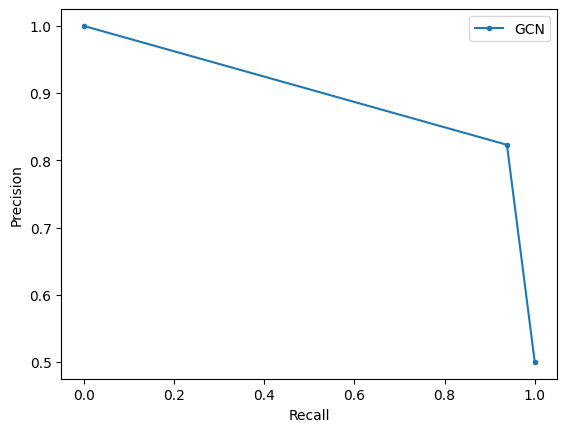

In [ ]:
pyplot.plot(recallVal, precisionVal, marker='.', label='GCN')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [ ]:
print(cf_matrix)

[[479 121]
 [ 37 563]]


<Axes: >

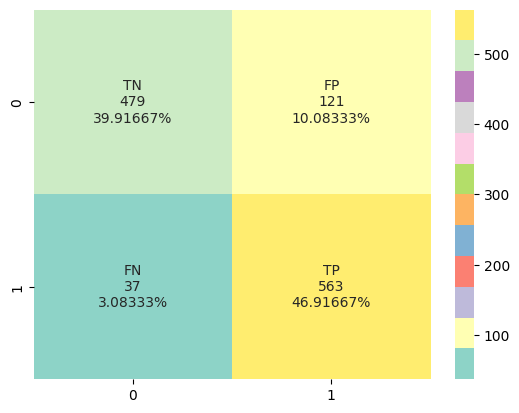

In [ ]:
group_names = ['TN','FP', 'FN', 'TP']
group_counts = ['{0:0.0f}'.format(value) for value in
                cf_matrix.flatten()]
group_percentages = ['{0:.5%}'.format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]
labels_conf= [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels_conf = np.asarray(labels_conf).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels_conf, fmt='', cmap='Set3')